## The Question

Build an image classifier (needs to be a machine learning model) which can detect the dominant color in images (preferably in Python)

1) It should be able to tell how confident the model is about the dominant color in the image irrespective of it's shape
2) The model should be able to detect at least 4 colors. 
3) Show the accuracy and error rates etc with the help of graphs (if possible)
4) Create a document or Jupyter notebook to explain the steps.  

You can create or download small image data set for this task from any source.



#### Importing the libraries and reading the data 

In [1]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#To ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Importing OpenCV - the computer vision library in python
import cv2

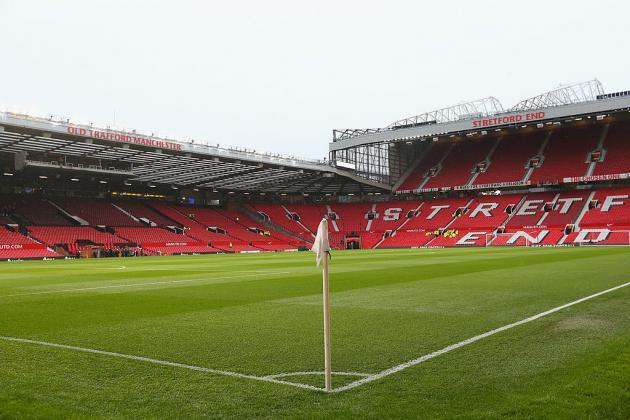

In [4]:
#To display the image 
from IPython.display import Image
Image('9oldtrafford.jpg')

In [5]:
#Reading the image
ot = cv2.imread('9oldtrafford.jpg')

([], <a list of 0 Text yticklabel objects>)

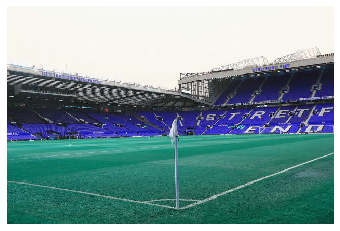

In [6]:
#Let's see how the image looks like after reading it in OpenCV
plt.imshow(ot)
plt.xticks([]) #To get rid of the x-ticks and y-ticks on the image axis
plt.yticks([])

This is certainly not how 'Old Trafford' looks like which is suggestive of the fact that we need to change the color channel. OpenCV follows BGR order whereas Matplotlib follows RGB order

In [7]:
#To convert the color channel 
ot = cv2.cvtColor(ot,cv2.COLOR_BGR2RGB)

([], <a list of 0 Text yticklabel objects>)

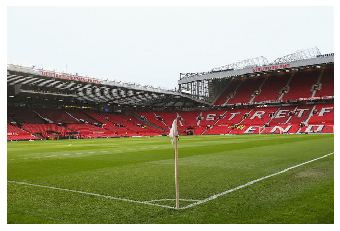

In [8]:
#To plot the image
plt.imshow(ot)
plt.xticks([])
plt.yticks([])

Yes. Now that the image looks like it should, we can go ahead.

In [9]:
#To print the number of pixels in the image
print('The number of pixels in this image is',len(ot[0]),'x',len(ot))
ot.shape

The number of pixels in this image is 630 x 420


(420, 630, 3)

Each pixel is represented by its R, G and B components. We will resize the image so that any machine learning algorithm that we apply later works faster. One thing to note here is that doing so won't alter it's properties (composition/proportion). We will also be reshaping the image so that we have a matrix of the length of the total number of pixels in the resized image with every row representing the R, G and B components of each pixel. 

In [10]:
#To resize the image and to keep the height and width proportion the same.
height = int(100 * (ot.shape[0]/ max(ot.shape[0],ot.shape[1])))
width = int(100 * (ot.shape[1]/ max(ot.shape[0],ot.shape[1])))
ot=cv2.resize(ot,(width,height))

([], <a list of 0 Text yticklabel objects>)

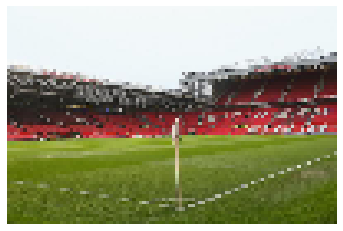

In [11]:
#To plot the image
plt.imshow(ot)
plt.xticks([])
plt.yticks([])

In [12]:
#To reshape it so that we now have a 2D matrix
ot=ot.reshape((ot.shape[0]*ot.shape[1],3))

Now we have the total number of pixels as the total number of observations. And we have 3 dimensions which are the R, G and B components of each pixel. The pixels are spread out in a 3D space and we can find similar pixels (similar coloured pixels) by using K-Means Clustering. The dominant colour will be the cluster with maximum number of pixels in it.

#### Color Prediction 

The RGB co-ordinates of some common colors and their different shades were taken from https://www.rapidtables.com/web/color/RGB_Color.html. After some initial data manipulation, the colors and their co-ordinates were saved in a csv file titled 'colorsrgb.csv'. I have considered five colors in the model - Red, Green, Blue, Black and White. For simplicity, I have omitted the co-ordinates of colors like turquoise (mixture of green and blue), grey (mixture of black and white) and the like. 

- Shades from Maroon Red to Orange Red + Deep Pink in the link have been considered as red
- Shades from Olive to Light Sea Green excluding Yellow have been considered as green
- Shades from Steel Blue to Medium Purple have been considered as blue
- The lightest shades of every color have been considered as white
- The darker shades of grey and the different shades of black have been considered as black

We will try to fit different classification models to the data and use the one that gives us the best result.

In [13]:
#To read the data
colors=pd.read_csv('colorsrgb.csv')

In [14]:
colors['color'].value_counts()

white    23
blue     23
green    20
red      16
black    10
Name: color, dtype: int64

In [15]:
#Dividing the data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(colors.drop('color',axis=1),colors['color'],test_size=0.3,
                                                   random_state=0)

In [16]:
#Importing the random forest classifier
from sklearn.ensemble import RandomForestClassifier
#Instantiating the random forest classifier
rfc = RandomForestClassifier(n_estimators=50)
#Fitting the classifier to X and Y train
rfc.fit(x_train,y_train)
rfc_pred = rfc.predict(x_test)
#Final score
np.mean(rfc_pred==y_test)

1.0

In [17]:
#Let's see the accuracy of the Random Forest Classifier on multiple trials to see if it drops down. We are doing 
#this so as to check the amount of noise in the data. Random Forest Classifier has an element of 
#randomness associated with it due to bagging. 
acc=[]
for i in range(10):
    rfc.fit(x_train,y_train)
    rfc_pred = rfc.predict(x_test)
    #Final score
    acc.append(np.mean(rfc_pred==y_test))
print(acc)

[0.9642857142857143, 0.9642857142857143, 0.9642857142857143, 0.9642857142857143, 0.9642857142857143, 0.9642857142857143, 0.9642857142857143, 0.9642857142857143, 0.9642857142857143, 0.9642857142857143]


Okay that's great. Random Forest Classifier consistently gives us an accuracy of 96.43%. On our first trial, it went all the way upto 100%. Let's see if other models can match/improve

In [18]:
#Importing the KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4)
#Fitting the model to the training data
knn.fit(x_train,y_train)
#To make predictions
knn_pred = knn.predict(x_test)
#Final score
np.mean(knn_pred==y_test)

0.9285714285714286

In [19]:
#Now let's try SVM. We'll use the Linear Support Vector Classifier that uses the One vs All strategy for multi-
#class classification where we train n classifiers for n classes
from sklearn.svm import LinearSVC
svc = LinearSVC()
#Fitting the data
svc.fit(x_train,y_train)
#To make predictions
svc_pred = svc.predict(x_test)
#Final score
np.mean(svc_pred==y_test)

0.9285714285714286

We'll use the Random Forest Model to make predictions for further RGB coordinates as it gives us the highest accuracy.

#### Clustering 

In [20]:
#Importing K-Means from the scikit-learn library
from sklearn.cluster import KMeans

Since K-Means randomly assigns a point as the cluster centroid at the beginning of the algorithm, we can get different clusters on each each run of the alogrithm. Therfore we will run it multiple times taking either the same number of clusters or/and different number of clusters. 5 has been set as the upper limit as the pictures that we are using will have 5-6 different colors at the maximum. We will use the predictions of the Random Forest Classifier on the cluster centroid of the biggest cluster i.e the cluster with most number of pixels in it on one particular runs of K-Means and these predictions will be stored in a list called 'majority'. The most commonly occuring prediction will be considered as the dominant color in the picture. 

We will consider the confidence as the normalised number of times the dominant color appears in the 'majority' list. The reason - If the same color is predicted to be the dominant color on multiple runs of the K-Means algorithm, it means that the model is really confident of that color being the dominant color. In this case our confidence could be a perfect 1. If not i.e if a different colour comes up on multiple runs of K-Means, it means that the model isn't really sure and this will be clearly indicated in the confidence metric.

In [21]:
from statistics import mode

In [22]:
#Making predictions using the cluster centroid of the biggest cluster
majority=[]
for i in [2,3,3,4,4,5,5]:
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(ot)
    majority.append(
        rfc.predict(
            pd.DataFrame(data=[kmeans.cluster_centers_[pd.Series(kmeans.labels_).value_counts().index[0]]],
             columns=['red','green','blue']))[0])
print('The dominant color is',mode(majority),'with a confidence of',
     pd.Series(majority).value_counts(normalize=True).iloc[0])

The dominant color is green with a confidence of 0.857142857143


This is great as the dominant color in the image is indeed green.

### Trying it on other images 

The different image names will be stored in a list called filenames. We will run a for loop iterating through each image and predicting the dominant color. The dominant color which is the label in this case will be stored in a list called col_labels. The final prediction will be stored in a list called col_pred. col_pred and col_labels will be used to get the accuracy of the image classifier.

In [23]:
filenames=['9oldtrafford.jpg','moon.jpg','redvelvet.jpg','cloudysky.jpg','funeral.png','starwars.jpeg',
          'playstation.png','hulk.jpg','magikarp.png','cake.jpg','chrismartin.jpg',
          'pavbhaji.jpg','seascape.jpg','bulbasaur.jpg','farm.jpg','tomatoes.png','blackpanther.png',
          'eragon.jpg','view.jpg','eggs.jpg']

In [24]:
col_labels=['green','blue','red','white','black','black','blue','green','red','white','black',
           'red','green','green','green','red','black','blue','blue','white']

In [29]:
#Let's dump the entire code in one cell. This is our final image classification algorithm
col_pred=[]
confidence=[]
for img in filenames:
    img = cv2.imread(img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    height = int(100 * (img.shape[0]/ max(img.shape[0],img.shape[1])))
    width = int(100 * (img.shape[1]/ max(img.shape[0],img.shape[1])))
    img=cv2.resize(img,(width,height))
    img=img.reshape((img.shape[0]*img.shape[1],3))
    majority=[]
    for i in [2,3,3,4,4,5,5]:
        kmeans=KMeans(n_clusters=i)
        kmeans.fit(img)
        majority.append(
        rfc.predict(
            pd.DataFrame(data=[kmeans.cluster_centers_[pd.Series(kmeans.labels_).value_counts().index[0]]],
             columns=['red','green','blue']))[0])
    confidence.append(pd.Series(majority).value_counts(normalize=True).iloc[0])
    col_pred.append(mode(majority))

#### Performance Evaluation 

In [30]:
pd.DataFrame(list(zip(filenames,col_labels,col_pred,confidence)),columns=['File Name','Actual Dominant Color',
                                                              'Predicted Dominant Color','Confidence'])

,File Name,Actual Dominant Color,Predicted Dominant Color,Confidence
0,9oldtrafford.jpg,green,green,0.857143
1,moon.jpg,blue,blue,1.000000
2,redvelvet.jpg,red,green,0.571429
3,cloudysky.jpg,white,white,0.857143
4,funeral.png,black,black,1.000000
5,starwars.jpeg,black,black,1.000000
6,playstation.png,blue,blue,1.000000
7,hulk.jpg,green,green,1.000000
8,magikarp.png,red,red,1.000000
9,cake.jpg,white,white,1.000000


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
#To print the accuracy, confusion matrix and the classification report
print('The Accuracy is',np.mean(np.array(col_labels)==np.array(col_pred))*100,'%')
print('\n')
print('Classification report:\n',classification_report(col_labels,col_pred))
cm=confusion_matrix(col_labels,col_pred)
print('Confusion matrix:\n',cm)

The Accuracy is 85.0 %


Classification report:
              precision    recall  f1-score   support

      black       0.67      1.00      0.80         4
       blue       1.00      1.00      1.00         4
      green       0.80      0.80      0.80         5
        red       1.00      0.50      0.67         4
      white       1.00      1.00      1.00         3

avg / total       0.88      0.85      0.84        20

Confusion matrix:
 [[4 0 0 0 0]
 [0 4 0 0 0]
 [1 0 4 0 0]
 [1 0 1 2 0]
 [0 0 0 0 3]]


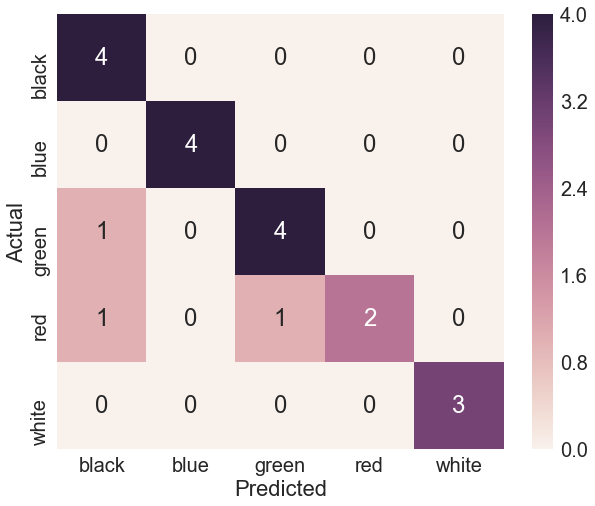

In [33]:
#To plot the confusion matrix
df_cm = pd.DataFrame(cm, index = [i for i in ['black','blue','green','red','white']],
                  columns = [i for i in ['black','blue','green','red','white']])
plt.figure(figsize = (10,8))
sns.set(font_scale=2)
sns.heatmap(df_cm, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

This is a basic solution to the problem of detecting dominant colors in images and in this regard the classifier has done sufficiently well. On the two images where 'Red' was the dominant color - pavbhaji.jpg and redvelvet.jpg, the plate/spoon/background has played a pivotal role in misclassification. Multiple runs of the image classifier algorithm will still yield an accuracy of 85%.